# Practical Activity 2 (**PRA2**)

## Evaluable Practical Exercise

<u>General considerations</u>:

- The proposed solution cannot use methods, functions or parameters declared **_deprecated_** in future versions.
- This activity must be carried out on a **strictly individual** basis. Any indication of copying will be penalized with a failure for all parties involved and the possible negative evaluation of the subject in its entirety.
- It is necessary for the student to indicate **all the sources** that she/he has used to carry out the PRA. If not, the student will be considered to have committed plagiarism, being penalized with a failure and the possible negative evaluation of the subject in its entirety.

<u>Delivery format</u>:

- Some exercises may require several minutes of execution, so the delivery must be done in **Notebook format** and in **HTML format**, where the code, results and comments of each exercise can be seen. You can export the notebook to HTML from the menu File $\to$ Download as $\to$ HTML.
- There is a special type of cell to hold text. This type of cell will be very useful to answer the different theoretical questions posed throughout the activity. To change the cell type to this type, in the menu: Cell $\to$ Cell Type $\to$ Markdown.

<div class="alert alert-block alert-info">
<strong>Name and surname: </strong> Martina Carretta (1673930)
</div>

## Introduction

[Lunar Lander](https://gymnasium.farama.org/environments/box2d/lunar_lander/) environment is part of the [Box2D](https://gymnasium.farama.org/environments/box2d/) environments. Lunar Lander is a classic rocket trajectory optimization problem. According to Pontryagin’s maximum principle, it is optimal to fire the engine at full throttle or turn it off. This is the reason why this environment has discrete actions: engine on or off.

There are two versions of the environment: discrete and continuous. The landing pad is always at the coordinates (0,0). The coordinates are the first two numbers in the state vector. Landing outside of the landing pad is possible. Fuel is infinite, so an agent can learn to fly and then land on its first attempt.

<img src="https://gymnasium.farama.org/_images/lunar_lander.gif" width="400px" />

More information can be found at:
- [Lunar Lander](https://gymnasium.farama.org/environments/box2d/lunar_lander/)

In order to initialize the environment, we will use the discrete action space `continuous=False`, as depicted in the following code:

<u>Notes</u>: The Lunar Lander environment requires the `box2d-py` library:
- Local environment:

> conda install swig

> pip install box2d-py

- Google Colab, always start notebook with:

> !pip install box2d-py

In [ ]:
# !pip install box2d-py -q
# !pip install "gymnasium[box2d]" -q

## Part 1. Deep Q-Networks

In the in-class examples and exercises, we have designed and implemented a Deep Q-Network (DQN) incorporating an experience replay buffer, target network, and the $\epsilon$-greedy exploration strategy.

For this exercise, you can reuse and adapt this code to meet your specific needs. Alternatively, you are encouraged to develop your own code or use third-party code examples (with appropriate citations in your activity submission).

<u>Questions</u> (**6 points**):

1. Implement a Baseline DQN: Develop a DQN model that includes an experience replay buffer, target network, and $\epsilon$-greedy method as a baseline.

2. Train and Tune: Train the baseline model and adjust its hyperparameters to optimize performance.

3. Report Metrics: Provide key metrics for the baseline model, such as rolling average reward, loss values, etc., similar to previous exercises.

4. Extensions (Choose 2 or more): Select and implement two (or more) of the following DQN extensions in your model:

- Prioritized Experience Replay Buffer
- N-step DQN (N=2)
- Double DQN
- Dueling DQN

5. For each extension:

- Add comments to the code to highlight the modifications made.
- Train the extended model and fine-tune its hyperparameters.
- Report the performance metrics and compare them to the baseline model.

<div class="alert alert-block alert-danger">
<strong>Solution</strong>
</div>

In [ ]:
import gymnasium as gym
import numpy as np
import torch
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from copy import deepcopy, copy
import wandb
import random
import itertools
import datetime

import torch.nn as nn
import torch.optim as optim
from PIL import Image

env = gym.make('LunarLander-v3')
print("Action space is {} ".format(env.action_space))
print(env.observation_space.shape)
print("Observation space is {} ".format(env.observation_space))
print(f"Reward threshold is {env.spec.reward_threshold}")

Action space is Discrete(4) 
(8,)
Observation space is Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32) 
Reward threshold is 200


### Baseline Implementation:

In [2]:
class DQN(torch.nn.Module):
    
    def __init__(self, env, learning_rate=1e-3, device='cpu'):
        super(DQN, self).__init__()
        self.device = device
        self.n_inputs = env.observation_space.shape[0]
        self.n_outputs = env.action_space.n
        self.actions = np.arange(env.action_space.n)
        self.learning_rate = learning_rate
        
        ### Construction of the neural network
        self.model = torch.nn.Sequential(
            torch.nn.Linear(self.n_inputs, 64, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 64, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(64, self.n_outputs, bias=True))
        
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        
        ### Work with CUDA is allowed
        if self.device == 'cuda':
            self.model.cuda()
            
    
    # e-greedy method
    def get_action(self, state, epsilon=0.05):
        if np.random.random() < epsilon:
            # random action
            action = np.random.choice(self.actions)  
        else:
            # Q-value based action
            qvals = self.get_qvals(state)  
            action= torch.max(qvals, dim=-1)[1].item()
        
        return action
    
    
    def get_qvals(self, state):
        if type(state) is tuple:
            state = np.array([np.ravel(s) for s in state])
        
        state_t = torch.FloatTensor(state).to(device=self.device)
        
        return self.model(state_t)

In [3]:
class DQNAgent:
    
    def __init__(self, env, dnnetwork, buffer, epsilon=0.1, eps_decay=0.99, batch_size=32):
        self.env = env
        self.dnnetwork = dnnetwork
        self.target_network = deepcopy(dnnetwork)
        self.buffer = buffer
        self.epsilon = epsilon
        self.eps_decay = eps_decay
        self.batch_size = batch_size
        # block of the last X episodes to calculate the average reward 
        self.nblock = 100 
        # average reward used to determine if the agent has learned to play
        self.reward_threshold = self.env.spec.reward_threshold 
        self.initialize()
    
    def initialize(self):
        self.update_loss = []
        self.training_rewards = []
        self.mean_training_rewards = []
        self.sync_eps = []
        self.total_reward = 0
        self.step_count = 0
        self.state0 = self.env.reset()[0]
        
    ## Take new action
    def take_step(self, eps, mode='train'):
        if mode == 'explore': 
            # random action in burn-in and in the exploration phase (epsilon)
            action = self.env.action_space.sample() 
        else:
            # Action based on the Q-value (max Q-value)
            action = self.dnnetwork.get_action(self.state0, eps)
            self.step_count += 1
            
        # Execute action and get reward and new state
        new_state, reward, terminated, truncated, _ = self.env.step(action)
        done = terminated or truncated
        self.total_reward += reward
        # save experience in the buffer
        self.buffer.append(self.state0, action, reward, done, new_state) 
        self.state0 = new_state.copy()
        
        if done:
            self.state0 = self.env.reset()[0]
        return done

            
    ## Training
    def train(self, gamma=0.99, max_episodes=50000, 
              batch_size=32,
              dnn_update_frequency=4,
              dnn_sync_frequency=2000):
        
        self.gamma = gamma

        # Fill the buffer with N random experiences
        print("Filling replay buffer...")
        while self.buffer.burn_in_capacity() < 1:
            self.take_step(self.epsilon, mode='explore')
            
        # Store metrics locally to plot
        self.episode_rewards = []
        self.mean_rewards = []
        self.epsilon_values = []
        self.loss_values = []
 
        episode = 0
        training = True
        print("Training...")
        while training:
            self.state0 = self.env.reset()[0]
            self.total_reward = 0
            gamedone = False
            while gamedone == False:
                # The agent takes an action
                gamedone = self.take_step(self.epsilon, mode='train')
               
                # Upgrade main network
                if self.step_count % dnn_update_frequency == 0:
                    self.update()
                # Synchronize the main network and the target network
                if self.step_count % dnn_sync_frequency == 0:
                    self.target_network.load_state_dict(
                        self.dnnetwork.state_dict())
                    self.sync_eps.append(episode)
                    
                if gamedone:                   
                    episode += 1
                    # Save the rewards
                    self.training_rewards.append(self.total_reward)
                    # Calculate the average reward for the last X episodes
                    if len(self.training_rewards) >= self.nblock:
                        mean_rewards = np.mean(self.training_rewards[-self.nblock:])
                    else:
                        mean_rewards = np.mean(self.training_rewards)  # Use all rewards if less than nblock
                    
                    self.mean_training_rewards.append(mean_rewards)

                    print("\rEpisode {:d} Mean Rewards {:.2f} Epsilon {}\t\t".format(episode, mean_rewards, self.epsilon), end="")
                    
                    wandb.log({
                        'episode': episode,
                        'mean_rewards': mean_rewards,
                        'episode reward': self.total_reward,
                        'epsilon': self.epsilon,
                        'loss': np.mean(self.update_loss)
                    }, step=episode)
                    
                    # Append metrics to lists for plotting
                    self.episode_rewards.append(self.total_reward)
                    self.mean_rewards.append(mean_rewards)
                    self.epsilon_values.append(self.epsilon)
                    self.loss_values.append(np.mean(self.update_loss))
                    
                    self.update_loss = []

                    # Check if there are still episodes left
                    if episode >= max_episodes:
                        training = False
                        print('\nEpisode limit reached.')
                        break
                    
                    # The game ends if the average reward has reached the threshold
                    if mean_rewards >= self.reward_threshold:
                        training = False
                        print('\nEnvironment solved in {} episodes!'.format(episode))
                        break
                    
                    # Update epsilon according to the fixed decay rate
                    self.epsilon = max(self.epsilon * self.eps_decay, 0.01)
                    torch.save(self.dnnetwork.state_dict(), "LunarLander-v3" + ".dat")
                    
        # PLOTTING
        fig, axes = plt.subplots(2, 2, figsize=(10, 8))  # Create a 2x2 grid of subplots
        axes = axes.ravel()  # Flatten the axes array for easier indexing

        # Plot episode rewards
        axes[0].plot(self.episode_rewards)
        axes[0].set_xlabel('Episode')
        axes[0].set_ylabel('Episode Reward')
        axes[0].set_title('Episode Rewards Over Time')

        # Plot mean rewards
        axes[1].plot(self.mean_rewards)
        axes[1].set_xlabel('Episode')
        axes[1].set_ylabel('Mean Reward')
        axes[1].set_title('Mean Rewards Over Time')

        # Plot epsilon values
        axes[2].plot(self.epsilon_values)
        axes[2].set_xlabel('Episode')
        axes[2].set_ylabel('Epsilon Values')
        axes[2].set_title('Epsilon Values Over Time')

        # Plot loss values
        axes[3].plot(self.loss_values)
        axes[3].set_xlabel('Episode')
        axes[3].set_ylabel('Loss')
        axes[3].set_title('Loss Over Time')

        # Adjust layout (optional)
        # fig.suptitle('Training Performance', fontsize=16)  # Add a main title
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust spacing between subplots and title
        plt.show()


    # Loss calculation           
    def calculate_loss(self, batch):
        # Separate the variables of the experience and convert them to tensors
        states, actions, rewards, dones, next_states = batch
        rewards_vals = torch.FloatTensor(rewards).to(device=self.dnnetwork.device) 
        actions_vals = torch.LongTensor(np.array(actions)).reshape(-1,1).to(device=self.dnnetwork.device)
        dones_t = torch.BoolTensor(dones).to(device=self.dnnetwork.device)
        
        # Obtain the Q values of the main network
        qvals = torch.gather(self.dnnetwork.get_qvals(states), 1, actions_vals)
        
        # Obtain the target Q values.
        # The detach() parameter prevents these values from updating the target network
        qvals_next = torch.max(self.target_network.get_qvals(next_states), dim=-1)[0].detach()
        # 0 in terminal states
        qvals_next[dones_t] = 0 
        
        # Calculate the Bellman equation
        expected_qvals = self.gamma * qvals_next + rewards_vals
        
        # Calculate the loss
        loss = torch.nn.MSELoss()(qvals, expected_qvals.reshape(-1,1))
        return loss
    

    def update(self):
        # Remove any gradient
        self.dnnetwork.optimizer.zero_grad()  
        # Select a subset from the buffer
        batch = self.buffer.sample_batch(batch_size=self.batch_size) 
        # Calculate the loss
        loss = self.calculate_loss(batch) 
        # Difference to get the gradients
        loss.backward() 
        # Apply the gradients to the neural network
        self.dnnetwork.optimizer.step() 
        # Save loss values
        if self.dnnetwork.device == 'cuda':
            self.update_loss.append(loss.detach().cpu().numpy())
        else:
            self.update_loss.append(loss.detach().numpy())

In [4]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)

    def append(self, state, action, reward, done, next_state):
        self.buffer.append((state, action, reward, done, next_state))

    def sample_batch(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, dones, next_states = zip(*batch)
        return (
            np.array(states, dtype=np.float32),
            np.array(actions, dtype=np.int64),
            np.array(rewards, dtype=np.float32),
            np.array(dones, dtype=np.bool_),
            np.array(next_states, dtype=np.float32),
        )

    def burn_in_capacity(self):
        return len(self.buffer) / self.capacity


In [5]:
LR = 0.001
MEMORY_SIZE = 100000
MAX_EPISODES = 5000
EPSILON = 0.99
EPSILON_DECAY = 0.995
GAMMA = 0.99
BATCH_SIZE = 64
BURN_IN = 1000
DNN_UPD = 1
DNN_SYNC = 2500

### Train:

In [7]:
wandb.login()

wandb.init(project="PML_PLAB2_LunarLander", config={
    "lr": LR,
    "MEMORY_SIZE": MEMORY_SIZE,
    "MAX_EPISODES": MAX_EPISODES,
    "EPSILON": EPSILON,
    "EPSILON_DECAY": EPSILON_DECAY,
    "GAMMA": GAMMA,
    "BATCH_SIZE": BATCH_SIZE,
    "BURN_IN": BURN_IN,
    "DNN_UPD": DNN_UPD,
    "DNN_SYNC": DNN_SYNC
})

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: martinacarrettab. Use `wandb login --relogin` to force relogin


>>> Training starts at  2024-11-24 16:05:36.763570
Filling replay buffer...
Training...
Episode 452 Mean Rewards 202.30 Epsilon 0.10323919533609638			
Environment solved in 452 episodes!


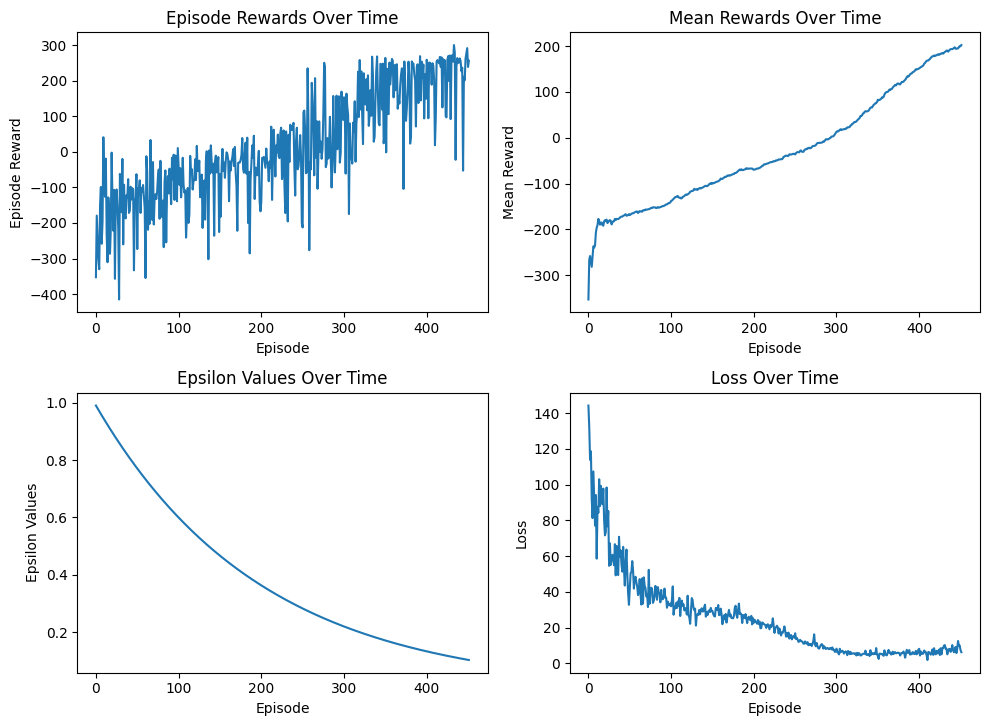

>>> Training completed at  2024-11-24 16:16:21.888321


In [8]:
print(">>> Training starts at ",datetime.datetime.now())

net = DQN (env, learning_rate=LR, device='cpu')
buffer = ReplayBuffer(capacity=MEMORY_SIZE)
agent = DQNAgent (env, net, buffer, epsilon=EPSILON, eps_decay=EPSILON_DECAY, batch_size=BATCH_SIZE)
agent.train(gamma=GAMMA, max_episodes=MAX_EPISODES, 
              batch_size=BATCH_SIZE,
              dnn_update_frequency=DNN_UPD,
              dnn_sync_frequency=DNN_SYNC)

print(">>> Training completed at ",datetime.datetime.now())

In [9]:
wandb.finish()

episode,▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇███
episode reward,▁▅▃▁▄▃▄▄▄▃▄▃▃▅▂▅▅▄▅▄▅▃▅▅▄▇▄▇██▆█▇▄▆█▅█▆█
epsilon,██▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁
loss,█▇▆▆▄▄▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_rewards,▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇█
episode,452
episode reward,256.91686
epsilon,0.10324
loss,6.21816
mean_rewards,202.30206


### Parameters Tune:

In [24]:
MAX_EPISODES = 500

In [ ]:
# Define your grid search parameters
param_grid = {
    'LR': [1e-4, 1e-3],
    'MEMORY_SIZE': [10000, 50000, 100000],
    'BATCH_SIZE': [32, 64, 128],
    'EPSILON_DECAY': [0.99, 0.995, 0.999],
    'GAMMA': [0.9, 0.99]
}

# Generate all combinations of parameters
param_combinations = list(itertools.product(
    param_grid['LR'], param_grid['MEMORY_SIZE'], param_grid['BATCH_SIZE'],
    param_grid['EPSILON_DECAY'], param_grid['GAMMA']
))

def run_training(lr, memory_size, batch_size, epsilon_decay, gamma):
    # Initialize wandb for each parameter combination
    wandb.init(
        project="PML_PLAB2_LunarLander_GridSearch",
        config={
            "LR": lr,
            "MEMORY_SIZE": memory_size,
            "BATCH_SIZE": batch_size,
            "EPSILON_DECAY": epsilon_decay,
            "GAMMA": gamma
        },
        reinit=True  # Ensures each run is logged as a new one
    )
    
    # Create environment and agent with the given parameters
    env = gym.make('LunarLander-v3')
    net = DQN(env, learning_rate=lr, device='cpu')
    buffer = ReplayBuffer(capacity=memory_size)
    agent = DQNAgent(env, net, buffer, epsilon=EPSILON, eps_decay=epsilon_decay, batch_size=batch_size)
    
    print(f"Running with parameters: LR={lr}, MEMORY_SIZE={memory_size}, BATCH_SIZE={batch_size}, EPSILON_DECAY={epsilon_decay}, GAMMA={gamma}")    
    # Train the agent
    agent.train(
        gamma=gamma,
        max_episodes=MAX_EPISODES,
        batch_size=batch_size,
        dnn_update_frequency=DNN_UPD,
        dnn_sync_frequency=DNN_SYNC
    )
        
    # Finish the current wandb run
    wandb.finish()

# Perform grid search
for params in param_combinations:
    run_training(*params)


### Metrics report:

<span style="color: lightblue;">

After running the grid search (which has the output cleared due to an extensive output), it has the following graph:


<img src="Baseline wandb.png" alt="Baseline WandB Graph" width="45%"/> <img src="Baseline mean.png" alt="Baseline WandB Graph" width="45%"/>


The one with the highest mean rewards is Lunar valley which has the following parameters:

- BATCH_SIZE = 64
- EPSILON_DECAY = 0.99
- GAMMA = 0.99
- LR = 0.0001
- MEMORY_SIZE = 100,000

This gives the following episodes rewards evolution (a step is an episode):

<img src="Baseline ep_rewards.png" alt="Baseline WandB Graph" width="50%"/>

The four combinations of the parameters that end up higher in the grid search all have in common:
- GAMMA = 0.99
- LR = 0.0001
- MEMORY_SIZE = 10.000

While the 4 that ended up last in the grid search have in common:
- GAMMA = 0.9

This makes me think that Gamma is a hyperparameter that does matter in the training of the agent. Gamma controls how the algorithm evaluates the rewards over time (if it gives mor importance to closer in time rewards or if it give the same importance to all the rewards in the case that the value of gamma was 1). 
Conversly, the batch size doesn't seem to matter (or at least it doesn't have a high effect when the 2 values evaluated are 32, 64, and 128). If i had tried with a higher difference maybe I would be able to perceive a difference. for example a batch of 8 and a batch of 512 would give differences due to small batches giving noisy gradients and slower convergence versus large batches giving smoother gradients but higher memory requirements.
Memory size refers to the size of the replay buffer. Typical replay buffer sizes range between 50.000 and 100.000. A smaller size is useful for environments with simpler dynamics (probably like Luna lander which doesn't have a lot of actions). It also means faster training since the algorithm needs to store fewer transitions. However, it might overfit to the seen experiences. A larger value needs more computational resources but helps with the stability. 

Of the mentioned best run, this is the loss:

<img src="Baseline loss.png" alt="Baseline WandB Graph" width="50%"/>

</span>

In [29]:
LR = 0.0001
MEMORY_SIZE = 100000
MAX_EPISODES = 5000
EPSILON = 0.99
EPSILON_DECAY = 0.995
GAMMA = 0.99
BATCH_SIZE = 64
BURN_IN = 1000
DNN_UPD = 1
DNN_SYNC = 2500

### Extensions - Prioritized experience buffer

<span style="color: lightblue;">

In order to implement the Prioritized experience buffer as well as the agent class.

In this extension of the standard DQN, the buffer asssigns priorities to experiences so that some of them are more likely to be sampled. Experiences with higher temporal difference errors are sampled more frquently.
- The variable priorities stores the priority of each experience.
- The new experiences are added with the maximum priority
- ```sample_batch``` samples experiences based on their scaled priority (which is the probs). This uses the alpha parameter to control how much prioritization is on the sampling
- the ```update_priorities``` updates them based on the TD error after the training. 

Additionally, the Agent class also needs to take into account this added variables of the ```weihts_t```, ```td_eror```, and ```new_priorities```
</span>

In [27]:
class PrioritizedReplayBuffer:
    def __init__(self, capacity, alpha=0.6):
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)
        self.priorities = deque(maxlen=capacity)  # Store priorities
        self.alpha = alpha  # Priority scaling factor

    def append(self, state, action, reward, done, next_state):
        max_priority = max(self.priorities, default=1.0)  # Assign max priority to new experiences
        self.buffer.append((state, action, reward, done, next_state))
        self.priorities.append(max_priority)

    def sample_batch(self, batch_size, beta=0.4):
        priorities = np.array(self.priorities, dtype=np.float32)
        scaled_priorities = priorities ** self.alpha
        probs = scaled_priorities / sum(scaled_priorities)

        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [self.buffer[idx] for idx in indices]
        states, actions, rewards, dones, next_states = zip(*samples)

        # Importance-sampling weights
        weights = (len(self.buffer) * probs[indices]) ** -beta
        weights /= max(weights)  # Normalize for stability

        return (
            np.array(states, dtype=np.float32),
            np.array(actions, dtype=np.int64),
            np.array(rewards, dtype=np.float32),
            np.array(dones, dtype=np.bool_),
            np.array(next_states, dtype=np.float32),
            indices,
            np.array(weights, dtype=np.float32),
        )

    def update_priorities(self, indices, priorities):
        for idx, priority in zip(indices, priorities):
            self.priorities[idx] = priority

    def burn_in_capacity(self):
        return len(self.buffer) / self.capacity

In [ ]:
class DQNAgent_prioritized:
    
    def __init__(self, env, dnnetwork, buffer, epsilon=0.1, eps_decay=0.99, batch_size=32):
        self.env = env
        self.dnnetwork = dnnetwork
        self.target_network = deepcopy(dnnetwork)
        self.buffer = buffer
        self.epsilon = epsilon
        self.eps_decay = eps_decay
        self.batch_size = batch_size
        # block of the last X episodes to calculate the average reward 
        self.nblock = 100 
        # average reward used to determine if the agent has learned to play
        self.reward_threshold = self.env.spec.reward_threshold 
        self.initialize()
    
    
    def initialize(self):
        self.update_loss = []
        self.training_rewards = []
        self.mean_training_rewards = []
        self.sync_eps = []
        self.total_reward = 0
        self.step_count = 0
        self.state0 = self.env.reset()[0]
        
    
    ## Take new action
    def take_step(self, eps, mode='train'):
        if mode == 'explore': 
            # random action in burn-in and in the exploration phase (epsilon)
            action = self.env.action_space.sample() 
        else:
            # Action based on the Q-value (max Q-value)
            action = self.dnnetwork.get_action(self.state0, eps)
            self.step_count += 1
            
        # Execute action and get reward and new state
        new_state, reward, terminated, truncated, _ = self.env.step(action)
        done = terminated or truncated
        self.total_reward += reward
        # save experience in the buffer
        self.buffer.append(self.state0, action, reward, done, new_state) 
        self.state0 = new_state.copy()
        
        if done:
            self.state0 = self.env.reset()[0]  
        return done
            
    ## Training
    def train(self, gamma=0.99, max_episodes=50000, 
              batch_size=32,
              dnn_update_frequency=4,
              dnn_sync_frequency=2000):
        
        self.gamma = gamma

        # Fill the buffer with N random experiences
        print("Filling replay buffer...")
        while self.buffer.burn_in_capacity() < 1:
            self.take_step(self.epsilon, mode='explore')
            
        # Store metrics locally to plot later
        self.episode_rewards = []
        self.mean_rewards = []
        self.epsilon_values = []
        self.loss_values = []
 
        episode = 0
        training = True
        print("Training...")
        while training:
            self.state0 = self.env.reset()[0]
            self.total_reward = 0
            gamedone = False
            while gamedone == False:
                # The agent takes an action
                gamedone = self.take_step(self.epsilon, mode='train')
               
                # Upgrade main network
                if self.step_count % dnn_update_frequency == 0:
                    self.update()
                # Synchronize the main network and the target network
                if self.step_count % dnn_sync_frequency == 0:
                    self.target_network.load_state_dict(
                        self.dnnetwork.state_dict())
                    self.sync_eps.append(episode)
                    
                if gamedone:                   
                    episode += 1
                    # Save the rewards
                    self.training_rewards.append(self.total_reward) 

                    # Calculate the average reward for the last X episodes
                    if len(self.training_rewards) >= self.nblock:
                        mean_rewards = np.mean(self.training_rewards[-self.nblock:])
                    else:
                        mean_rewards = np.mean(self.training_rewards)  # Use all rewards if less than nblock
                    
                    self.mean_training_rewards.append(mean_rewards)

                    print("\rEpisode {:d} Mean Rewards {:.2f} Epsilon {}\t\t".format(episode, mean_rewards, self.epsilon), end="")
                    
                    wandb.log({
                        'episode': episode,
                        'mean_rewards': mean_rewards,
                        'episode reward': self.total_reward,
                        'epsilon': self.epsilon,
                        'loss': np.mean(self.update_loss)
                    }, step=episode)
                    
                    # Append metrics to lists for plotting
                    self.episode_rewards.append(self.total_reward)
                    self.mean_rewards.append(mean_rewards)
                    self.epsilon_values.append(self.epsilon)
                    self.loss_values.append(np.mean(self.update_loss))

                    self.update_loss = [] # HO he mogut!! que abans no es calculava bé la loss

                    # Check if there are still episodes left
                    if episode >= max_episodes:
                        training = False
                        print('\nEpisode limit reached.')
                        break
                    
                    # The game ends if the average reward has reached the threshold
                    if mean_rewards >= self.reward_threshold:
                        training = False
                        print('\nEnvironment solved in {} episodes!'.format(episode))
                        break
                    
                    # Update epsilon according to the fixed decay rate
                    self.epsilon = max(self.epsilon * self.eps_decay, 0.01)
                    torch.save(self.dnnetwork.state_dict(), "LunarLander-v3" + ".dat")
                    
        #PLOTTING
        axes = plt.subplots(2, 2, figsize=(10, 8))  # Create a 2x2 grid of subplots
        axes = axes.ravel()  # Flatten the axes array for easier indexing

        # Plot episode rewards
        axes[0].plot(self.episode_rewards)
        axes[0].set_xlabel('Episode')
        axes[0].set_ylabel('Episode Reward')
        axes[0].set_title('Episode Rewards Over Time')

        # Plot mean rewards
        axes[1].plot(self.mean_rewards)
        axes[1].set_xlabel('Episode')
        axes[1].set_ylabel('Mean Reward')
        axes[1].set_title('Mean Rewards Over Time')

        # Plot epsilon values
        axes[2].plot(self.epsilon_values)
        axes[2].set_xlabel('Episode')
        axes[2].set_ylabel('Epsilon Values')
        axes[2].set_title('Epsilon Values Over Time')

        # Plot loss values
        axes[3].plot(self.loss_values)
        axes[3].set_xlabel('Episode')
        axes[3].set_ylabel('Loss')
        axes[3].set_title('Loss Over Time')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust spacing between subplots and title
        plt.show()

       
    ## Loss calculation           
    def calculate_loss(self, batch):
        states, actions, rewards, dones, next_states, indices, weights = batch
        rewards_vals = torch.FloatTensor(rewards).to(device=self.dnnetwork.device)
        actions_vals = torch.LongTensor(np.array(actions)).reshape(-1, 1).to(device=self.dnnetwork.device)
        dones_t = torch.BoolTensor(dones).to(device=self.dnnetwork.device)
        weights_t = torch.FloatTensor(weights).to(device=self.dnnetwork.device)

        qvals = torch.gather(self.dnnetwork.get_qvals(states), 1, actions_vals)
        qvals_next = torch.max(self.target_network.get_qvals(next_states), dim=-1)[0].detach()
        qvals_next[dones_t] = 0

        expected_qvals = self.gamma * qvals_next + rewards_vals

        # Compute weighted loss
        td_error = qvals - expected_qvals.reshape(-1, 1)
        loss = (td_error.pow(2) * weights_t).mean()

        # Update priorities
        new_priorities = (abs(td_error) + 1e-6).detach().cpu().numpy().flatten()
        self.buffer.update_priorities(indices, new_priorities)

        return loss

    

    def update(self):
        # Remove any gradient
        self.dnnetwork.optimizer.zero_grad()  
        # Select a subset from the buffer
        batch = self.buffer.sample_batch(batch_size=self.batch_size) 
        # Calculate the loss
        loss = self.calculate_loss(batch) 
        loss.backward() 
        # Apply the gradients to the neural network
        self.dnnetwork.optimizer.step() 
        # Save loss values
        if self.dnnetwork.device == 'cuda':
            self.update_loss.append(loss.detach().cpu().numpy())
        else:
            self.update_loss.append(loss.detach().numpy())

In [35]:
ALPHA = 0.6
BETA = 0.4

LR = 0.001
MEMORY_SIZE = 100000
MAX_EPISODES = 500
EPSILON = 0.99
EPSILON_DECAY = 0.995
GAMMA = 0.99
BATCH_SIZE = 64
BURN_IN = 1000
DNN_UPD = 1
DNN_SYNC = 2500

In [ ]:
wandb.login()

# start a new wandb run to track this script
wandb.init(project="PML_PLAB2_LunarLander", config={
    "lr": LR,
    "MEMORY_SIZE": MEMORY_SIZE,
    "MAX_EPISODES": MAX_EPISODES,
    "EPSILON": EPSILON,
    "EPSILON_DECAY": EPSILON_DECAY,
    "GAMMA": GAMMA,
    "BATCH_SIZE": BATCH_SIZE,
    "BURN_IN": BURN_IN,
    "DNN_UPD": DNN_UPD,
    "DNN_SYNC": DNN_SYNC,
    "PRIORITIZED": True # Per diferenciar
})

print(">>> Training starts at ",datetime.datetime.now())

>>> Training starts at  2024-11-25 01:09:19.756716


Filling replay buffer...
Training...
Episode 500 Mean Rewards 90.84 Epsilon 0.08116195258881968				
Episode limit reached.


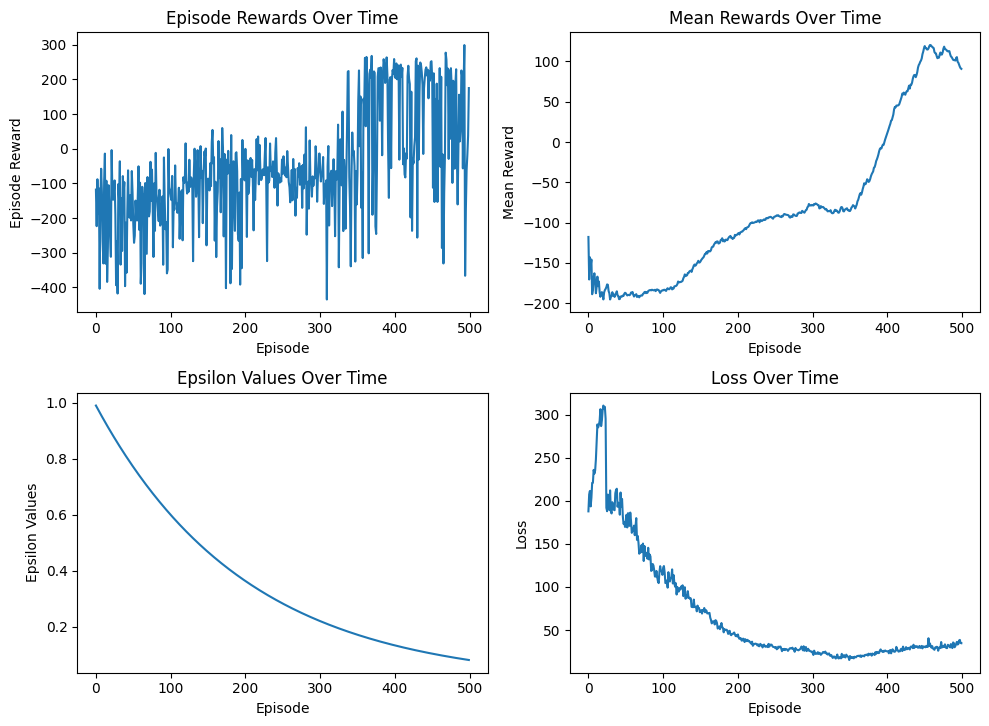

>>> Training completed at  2024-11-25 03:51:28.153419


In [37]:
net = DQN (env, learning_rate=LR, device='cpu')

buffer = PrioritizedReplayBuffer(capacity=MEMORY_SIZE)

agent = DQNAgent_prioritized (env, net, buffer, epsilon=EPSILON, eps_decay=EPSILON_DECAY, batch_size=BATCH_SIZE)

agent.train(gamma=GAMMA, max_episodes=MAX_EPISODES, 
              batch_size=BATCH_SIZE,
              dnn_update_frequency=DNN_UPD,
              dnn_sync_frequency=DNN_SYNC)

print(">>> Training completed at ",datetime.datetime.now())

In [ ]:
wandb.finish()

episode,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
episode reward,▁▄▂▄▄▄▄▂▂▄▅▃▄▂▄▄▄▁▄▅▅▄▆▄▄▃▂▇███▄▅▇▅██▅▅▆
epsilon,██▇▇▆▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
loss,█▅▆▅▅▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_rewards,▁▁▁▁▁▁▁▁▁▁▁▂▃▃▃▃▃▃▃▃▃▃▃▃▄▃▃▃▃▃▄▄▄▅▅▆▇▇██
episode,500
episode reward,175.23595
epsilon,0.08116
loss,34.77501
mean_rewards,90.83763


<span style="color: lightblue;">

Due to the time it took to run it, i tried parameters but they are not in the notebook because i tried them in another notebook so that i could work with this one in the mean time.

The parameters that seemed to work better are the ones i have in this run of the section

This extension did not converge completely but the highest mean reward happened about 200 episodes later compared to the baseline. After that, it just kind of flatlined. 
With exception of the first peak, the loss evolution was much smoother than the baseline's 

</span>

### Extensions - Dueling:

<span style="color: lightblue;">
For the duelling, the idea is to improve the convergence speed. To do so, we separate the q values in two different parts:

- The value of being in a state (V(s))
- The value of selecting the action in a specific state. A(s, a)

Until now, the last layer would use something like for example a SoftMax where the number of outputs should be the number of actions.
In duelling DQN, the algorithm separates the last part into the previously mentioned values. 
So, we have a value for the state and an arrray of different values (one for each action). We need to integrate and keep the values in the same range. 
</span>

<span style="color: lightblue;">
To implement these changes, we need to add two variables. 
One is the value stream which outputs a single state-value while the advantage stream outputs

- The init function now has the feature extraction layers we already had and, in addition, the 2 output variables. 
- in the ```get_qvals```, we pass the ```state_t``` through the neural network as we usually would, and then this will give features that will go throught the linear layers of ```value_stream``` and ```advantage_stream``` to get the state value and the advantage respectively. These two last will compute the q values through ```state_value + (advantages - advantages.mean(dim=-1, keepdim=True))```

</span>

In [ ]:
class DuelingDQN(torch.nn.Module):
    
    def __init__(self, env, learning_rate=1e-3, device='cpu'):
        super(DuelingDQN, self).__init__()
        self.device = device
        self.n_inputs = env.observation_space.shape[0]
        self.n_outputs = env.action_space.n
        self.actions = np.arange(env.action_space.n)
        self.learning_rate = learning_rate
        
        ### Construction of the neural network
        # Shared feature extraction layers
        self.feature_layer = torch.nn.Sequential(
            torch.nn.Linear(self.n_inputs, 64, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 64, bias=True),
            torch.nn.ReLU()
        )
        
        # Separate streams for state-value and advantage
        self.value_stream = torch.nn.Sequential(
            torch.nn.Linear(64, 1, bias=True)  # Outputs a single state-value
        )
        
        self.advantage_stream = torch.nn.Sequential(
            torch.nn.Linear(64, self.n_outputs, bias=True)  #  advantages for each action
        )
        
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        
        ### Work with CUDA is allowed
        if self.device == 'cuda':
            self.to(self.device)
            
    ### e-greedy method
    def get_action(self, state, epsilon=0.05):
        if np.random.random() < epsilon:
            # random action
            action = np.random.choice(self.actions)  
        else:
            # Q-value based action
            qvals = self.get_qvals(state)  
            action = torch.max(qvals, dim=-1)[1].item()
        
        return action
    
    def get_qvals(self, state):
        if type(state) is tuple:
            state = np.array([np.ravel(s) for s in state])
        
        state_t = torch.FloatTensor(state).to(device=self.device)
        features = self.feature_layer(state_t)
        
        # Compute state-value and advantages
        state_value = self.value_stream(features)
        advantages = self.advantage_stream(features)
        
        # Calculate Q-values
        qvals = state_value + (advantages - advantages.mean(dim=-1, keepdim=True))
        
        return qvals

<span style="color: lightblue;">
Now that the duelling is implemented, i will perform grid search to find which of these hyperparameter values works better.
</span>

In [ ]:
MAX_EPISODES = 500

In [ ]:
# Define your grid search parameters
param_grid = {
    'LR': [1e-4, 1e-3],
    'EPSILON_DECAY': [0.99, 0.995],
    'GAMMA': [0.9, 0.99]
}

# Generate all combinations of parameters
param_combinations = list(itertools.product(
    param_grid['LR'], param_grid['EPSILON_DECAY'], param_grid['GAMMA']
))

def run_training(lr, epsilon_decay, gamma):
    # Initialize wandb for each parameter combination
    wandb.init(
        project="PML_PLAB2_LunarLander_GridSearch_Dueling",
        config={
            "LR": lr,
            "EPSILON_DECAY": epsilon_decay,
            "GAMMA": gamma
        },
        reinit=True  # Ensures each run is logged as a new one
    )
    
    # Create environment and agent with the given parameters
    env = gym.make('LunarLander-v3')
    net = DuelingDQN(env, learning_rate=lr, device='cpu')
    buffer = ReplayBuffer(capacity=MEMORY_SIZE)
    agent = DQNAgent(env, net, buffer, epsilon=EPSILON, eps_decay=epsilon_decay, batch_size=BATCH_SIZE)
    
    
    print(f"Running with parameters: LR={lr}, MEMORY_SIZE={MEMORY_SIZE}, BATCH_SIZE={BATCH_SIZE}, EPSILON_DECAY={epsilon_decay}, GAMMA={gamma}")
    print(">>> Training starts at ", datetime.datetime.now())
    
    # Train the agent
    agent.train(
        gamma=gamma,
        max_episodes=500, # 500
        batch_size=BATCH_SIZE,
        dnn_update_frequency=DNN_UPD,
        dnn_sync_frequency=DNN_SYNC
    )
    
    print(">>> Training completed at ", datetime.datetime.now())
    
    # Finish the current wandb run
    wandb.finish()

# Perform grid search
for params in param_combinations:
    run_training(*params)

<span style="color: lightblue;">

After running the grid search (which has the output cleared due to an extensive output), it has the following graph:


<img src="Duelling wandb.png" alt="Baseline WandB Graph" width="45%"/> <img src="Duelling mean.png" alt="Duelling loss Graph" width="45%"/>

The one with the highest mean rewards is called "Kind bush" and has the following parameters:

- EPSILON_DECAY = 0.99
- GAMMA = 0.99
- LR = 0.001

This gives the following episodes rewards evolution:

<img src="Duelling ep_rewards.png" alt="Baseline WandB Graph" width="50%"/>

And the following loss:

<img src="Duelling loss.png" alt="Duelling loss Graph" width="50%"/>

The four combinations of the parameters that end up higher in the grid search all have in common:
- GAMMA = 0.99

While the 4 that ended up last in the grid search have in common:
- GAMMA = 0.9

This, again, shows just how important the value of gamma is.

</span>

In [6]:
LR = 0.001
MEMORY_SIZE = 100000
MAX_EPISODES = 5000
EPSILON = 0.99
EPSILON_DECAY = 0.995
GAMMA = 0.99
BATCH_SIZE = 64
BURN_IN = 1000
DNN_UPD = 1
DNN_SYNC = 2500

In [7]:
wandb.login()

# start a new wandb run to track this script
wandb.init(project="PML_PLAB2_LunarLander", config={
    "lr": LR,
    "MEMORY_SIZE": MEMORY_SIZE,
    "MAX_EPISODES": MAX_EPISODES,
    "EPSILON": EPSILON,
    "EPSILON_DECAY": EPSILON_DECAY,
    "GAMMA": GAMMA,
    "BATCH_SIZE": BATCH_SIZE,
    "BURN_IN": BURN_IN,
    "DNN_UPD": DNN_UPD,
    "DNN_SYNC": DNN_SYNC,
    "DUELING": True
})

print(">>> Training starts at ",datetime.datetime.now())

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: martinacarrettab. Use `wandb login --relogin` to force relogin


>>> Training starts at  2024-11-25 12:35:26.951292


Filling replay buffer...
Training...
Episode 436 Mean Rewards 200.64 Epsilon 0.11186012981287036			
Environment solved in 436 episodes!


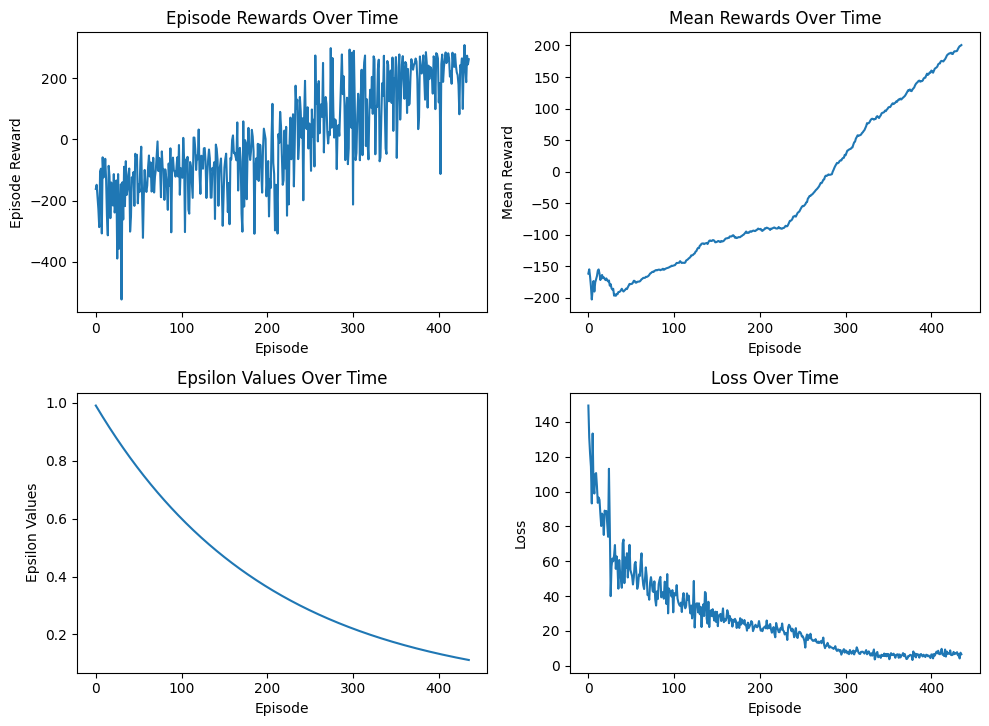

>>> Training completed at  2024-11-25 12:31:52.081251


In [66]:
net = DuelingDQN (env, learning_rate=LR, device='cpu')

buffer = ReplayBuffer(capacity=MEMORY_SIZE)

agent = DQNAgent (env, net, buffer, epsilon=EPSILON, eps_decay=EPSILON_DECAY, batch_size=BATCH_SIZE)

agent.train(gamma=GAMMA, max_episodes=MAX_EPISODES, 
              batch_size=BATCH_SIZE,
              dnn_update_frequency=DNN_UPD,
              dnn_sync_frequency=DNN_SYNC)

print(">>> Training completed at ",datetime.datetime.now())

In [67]:
wandb.finish()

episode,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇█
episode reward,▂▁▄▁▂▄▁▃▄▄▄▄▃▃▃▄▅▅▄▃▆▅█▆▆▇▆▇▇██▆▇▇▆▇█▇▇▇
epsilon,████▇▆▆▅▅▅▄▄▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▆▆▄▅▃▄▃▄▃▃▃▂▂▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_rewards,▂▁▁▁▁▂▂▂▂▂▂▃▂▃▃▃▃▃▃▃▃▃▃▃▄▄▄▅▆▆▇▇▇▇▇▇▇▇▇█
episode,436
episode reward,261.37074
epsilon,0.11186
loss,6.63678
mean_rewards,200.64008


<span style="color: lightblue;">

After the results from the grid search, the agent training we get is one that has a smoother loss evolution but converges right after the DQN one. However, i don't think the difference is very significant. I believe that if I played a little bit more with the hyperparameters and run several tests, the DQN and the dueling one would be very close
</span>

### Extensions - N-step DQN (n=2)

<span style="color: lightblue;">

For this extension, we unroll and try to look 3 or more steps further than the actual state. 
We can expect that if we have a large number of steps ahead, we will get a huge improvement in the convergence of the algorithm. However, if we use a large value of n (number of steps), the model won't converge and it will be very unstable. Once we have added some kind of error in the following steps, we are accumulating a lot of errors. Usually, we don’t use values far from 2 or 3 in the number of steps. 

</span>

<span style="color: lightblue;">

To implement it, we need to change the replay buffer and the agent class.
- In the append function of the buffer, we need to append as many states as n until the condition ```len(self.n_step_buffer) == self.n_step``` is satisfied. if so, it will take the state and action of the first step and the n-step return (sum of rewards) (using the ```_get_n_step_info``` method) to append it to the buffer.
- Regarding the agent class, in the loss calculation, the bellman equation changes a little bit. The gamma is changed to gamma to the power of ```self.buffer.n_step```, in this case, 2:
```expected_qvals = self.gamma ** self.buffer.n_step * qvals_next + rewards_vals```


</span>

In [19]:
class NStepReplayBuffer:
    def __init__(self, capacity, n_step=2, gamma=0.99):
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)
        self.n_step = n_step
        self.gamma = gamma
        self.n_step_buffer = deque(maxlen=n_step)

    def append(self, state, action, reward, done, next_state):
        # Store the transition temporarily
        self.n_step_buffer.append((state, action, reward, done, next_state))

        # If the n-step buffer is ready, calculate the n-step return and append to buffer
        if len(self.n_step_buffer) == self.n_step:
            state, action, _, _, _ = self.n_step_buffer[0]
            reward, next_state, done = self._get_n_step_info()
            self.buffer.append((state, action, reward, done, next_state))
        
        # If the episode ends, clear the n-step buffer
        if done:
            self.n_step_buffer.clear()

    def _get_n_step_info(self):
        """Calculate the n-step return."""
        reward, next_state, done = 0, None, False
        for idx, (_, _, r, d, ns) in enumerate(self.n_step_buffer):
            reward += (self.gamma ** idx) * r
            next_state = ns
            done = d
            if done:
                break
        return reward, next_state, done

    def sample_batch(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, dones, next_states = zip(*batch)
        return (
            np.array(states, dtype=np.float32),
            np.array(actions, dtype=np.int64),
            np.array(rewards, dtype=np.float32),
            np.array(dones, dtype=np.bool_),
            np.array(next_states, dtype=np.float32),
        )

    def burn_in_capacity(self):
        return len(self.buffer) / self.capacity

In [ ]:
class NstepDQNAgent:
    
    def __init__(self, env, dnnetwork, buffer, epsilon=0.1, eps_decay=0.99, batch_size=32):
        self.env = env
        self.dnnetwork = dnnetwork
        self.target_network = deepcopy(dnnetwork)
        self.buffer = buffer
        self.epsilon = epsilon
        self.eps_decay = eps_decay
        self.batch_size = batch_size
        # block of the last X episodes to calculate the average reward 
        self.nblock = 100 
        # average reward used to determine if the agent has learned to play
        self.reward_threshold = self.env.spec.reward_threshold 
        
        self.initialize()
    
    
    def initialize(self):
        self.update_loss = []
        self.training_rewards = []
        self.mean_training_rewards = []
        self.sync_eps = []
        self.total_reward = 0
        self.step_count = 0
        self.state0 = self.env.reset()[0]
        
    
    ## Take new action
    def take_step(self, eps, mode='train'):
        if mode == 'explore': 
            # random action in burn-in and in the exploration phase (epsilon)
            action = self.env.action_space.sample() 
        else:
            # Action based on the Q-value (max Q-value)
            action = self.dnnetwork.get_action(self.state0, eps)
            self.step_count += 1
            
        # Execute action and get reward and new state
        new_state, reward, terminated, truncated, _ = self.env.step(action)
        done = terminated or truncated
        self.total_reward += reward

        self.buffer.append(self.state0, action, reward, done, new_state) # save experience in the buffer
        self.state0 = new_state.copy()
        
        if done:
            self.state0 = self.env.reset()[0]
        
        return done

            
    ## Training
    def train(self, gamma=0.99, max_episodes=50000, 
              batch_size=32,
              dnn_update_frequency=4,
              dnn_sync_frequency=2000):
        
        self.gamma = gamma

        # Fill the buffer with N random experiences
        print("Filling replay buffer...")
        while self.buffer.burn_in_capacity() < 1:
            self.take_step(self.epsilon, mode='explore')
            
        # Store metrics locally to plot later
        self.episode_rewards = []
        self.mean_rewards = []
        self.epsilon_values = []
        self.loss_values = []

 
        episode = 0
        training = True
        print("Training...")
        while training:
            self.state0 = self.env.reset()[0]
            self.total_reward = 0
            gamedone = False
            while gamedone == False:
                # The agent takes an action
                gamedone = self.take_step(self.epsilon, mode='train')
               
                # Upgrade main network
                if self.step_count % dnn_update_frequency == 0:
                    self.update()
                # Synchronize the main network and the target network
                if self.step_count % dnn_sync_frequency == 0:
                    self.target_network.load_state_dict(
                        self.dnnetwork.state_dict())
                    self.sync_eps.append(episode)
                    
                if gamedone:                   
                    episode += 1
                    # Save the rewards
                    self.training_rewards.append(self.total_reward) 

                    # Calculate the average reward for the last X episodes
                    if len(self.training_rewards) >= self.nblock:
                        mean_rewards = np.mean(self.training_rewards[-self.nblock:])
                    else:
                        mean_rewards = np.mean(self.training_rewards)  # Use all rewards if less than nblock
                    
                    self.mean_training_rewards.append(mean_rewards)

                    print("\rEpisode {:d} Mean Rewards {:.2f} Epsilon {}\t\t".format(episode, mean_rewards, self.epsilon), end="")
                    
                    wandb.log({
                        'episode': episode,
                        'mean_rewards': mean_rewards,
                        'episode reward': self.total_reward,
                        'epsilon': self.epsilon,
                        'loss': np.mean(self.update_loss)
                    }, step=episode)
                    
                    # Append metrics to lists for plotting
                    self.episode_rewards.append(self.total_reward)
                    self.mean_rewards.append(mean_rewards)
                    self.epsilon_values.append(self.epsilon)
                    self.loss_values.append(np.mean(self.update_loss))

                    self.update_loss = []
                    
                    # Check if there are still episodes left
                    if episode >= max_episodes:
                        training = False
                        print('\nEpisode limit reached.')
                        break
                    
                    # The game ends if the average reward has reached the threshold
                    if mean_rewards >= self.reward_threshold:
                        training = False
                        print('\nEnvironment solved in {} episodes!'.format(episode))
                        break
                    
                    # Update epsilon according to the fixed decay rate
                    self.epsilon = max(self.epsilon * self.eps_decay, 0.01)
                    torch.save(self.dnnetwork.state_dict(), "LunarLander-v3" + ".dat")
                    
        #PLOTTING
        axes = plt.subplots(2, 2, figsize=(10, 8))  # Create a 2x2 grid of subplots
        axes = axes.ravel()  # Flatten the axes array for easier indexing

        # Plot episode rewards
        axes[0].plot(self.episode_rewards)
        axes[0].set_xlabel('Episode')
        axes[0].set_ylabel('Episode Reward')
        axes[0].set_title('Episode Rewards Over Time')

        # Plot mean rewards
        axes[1].plot(self.mean_rewards)
        axes[1].set_xlabel('Episode')
        axes[1].set_ylabel('Mean Reward')
        axes[1].set_title('Mean Rewards Over Time')

        # Plot epsilon values
        axes[2].plot(self.epsilon_values)
        axes[2].set_xlabel('Episode')
        axes[2].set_ylabel('Epsilon Values')
        axes[2].set_title('Epsilon Values Over Time')

        # Plot loss values
        axes[3].plot(self.loss_values)
        axes[3].set_xlabel('Episode')
        axes[3].set_ylabel('Loss')
        axes[3].set_title('Loss Over Time')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust spacing between subplots and title
        plt.show()
                    
                
    ## Loss calculation           
    def calculate_loss(self, batch):
        states, actions, rewards, dones, next_states = [i for i in batch]
        rewards_vals = torch.FloatTensor(rewards).to(device=self.dnnetwork.device)
        actions_vals = torch.LongTensor(np.array(actions)).reshape(-1, 1).to(device=self.dnnetwork.device)
        dones_t = torch.BoolTensor(dones).to(device=self.dnnetwork.device)

        # Q-values of the main network
        qvals = torch.gather(self.dnnetwork.get_qvals(states), 1, actions_vals)

        # Target Q-values
        qvals_next = torch.max(self.target_network.get_qvals(next_states), dim=-1)[0].detach()
        qvals_next[dones_t] = 0  # No Q-value for terminal states

        # Bellman equation with n-step returns
        expected_qvals = self.gamma ** self.buffer.n_step * qvals_next + rewards_vals

        # Loss calculation
        loss = torch.nn.MSELoss()(qvals, expected_qvals.reshape(-1, 1))
        return loss

    def update(self):
        # Remove any gradient
        self.dnnetwork.optimizer.zero_grad()  
        # Select a subset from the buffer
        batch = self.buffer.sample_batch(batch_size=self.batch_size) 
        # Calculate the loss
        loss = self.calculate_loss(batch) 
        # Difference to get the gradients
        loss.backward() 
        # Apply the gradients to the neural network
        self.dnnetwork.optimizer.step() 
        # Save loss values
        if self.dnnetwork.device == 'cuda':
            self.update_loss.append(loss.detach().cpu().numpy())
        else:
            self.update_loss.append(loss.detach().numpy())

<span style="color: lightblue;">

Now that the N-step is implemented, i will perform the grid search and then try the algorithm with the best parameters.

I have changed the hyperparameters to values that are more different to see if i can spot other parameter values that are more important and affect the performance
</span>

In [21]:
MAX_EPISODES = 500
wandb.finish()

In [ ]:
# Define your grid search parameters
param_grid = {
    'LR': [1e-3, 1e-2],
    'EPSILON_DECAY': [0.9, 0.995],
    'GAMMA': [0.9, 0.99]
}
# Generate all combinations of parameters
param_combinations = list(itertools.product(
    param_grid['LR'], param_grid['EPSILON_DECAY'], param_grid['GAMMA']
))

def run_training(lr, epsilon_decay, gamma):
    # Initialize wandb for each parameter combination
    wandb.init(
        project="PML_PLAB2_LunarLander_GridSearch_NStep",
        config={
            "LR": lr,
            "EPSILON_DECAY": epsilon_decay,
            "GAMMA": gamma
        },
        reinit=True  # Ensures each run is logged as a new one
    )
    
    # Create environment and agent with the given parameters
    env = gym.make('LunarLander-v3')
    net = DQN(env, learning_rate=lr, device='cpu')
    buffer = NStepReplayBuffer(capacity=MEMORY_SIZE)
    agent = NstepDQNAgent(env, net, buffer, epsilon=EPSILON, eps_decay=epsilon_decay, batch_size=BATCH_SIZE)
    
    
    print(f"Running with parameters: LR={lr}, MEMORY_SIZE={MEMORY_SIZE}, BATCH_SIZE={BATCH_SIZE}, EPSILON_DECAY={epsilon_decay}, GAMMA={gamma}")
    print(">>> Training starts at ", datetime.datetime.now())
    
    # Train the agent
    agent.train(
        gamma=gamma,
        max_episodes=MAX_EPISODES, # 500
        batch_size=BATCH_SIZE,
        dnn_update_frequency=DNN_UPD,
        dnn_sync_frequency=DNN_SYNC
    )
    
    print(">>> Training completed at ", datetime.datetime.now())
    
    # Finish the current wandb run
    wandb.finish()

# Perform grid search
for params in param_combinations:
    run_training(*params)

<span style="color: lightblue;">

After running the grid search (which has the output cleared due to an extensive output), it has the following graph:


<img src="nstep wandb.png" alt="Baseline WandB Graph" width="45%"/> <img src="nstep mean.png" alt="Baseline WandB Graph" width="45%"/>



The one with the highest mean rewards is Lunar valley which has the following parameters:

- EPSILON_DECAY = 0.9
- GAMMA = 0.99
- LR = 0.001

This gives the following episodes rewards evolution:

<img src="nstep ep_rewards.png" alt="Baseline WandB Graph" width="50%"/>

And the following loss:

<img src="nstep loss.png" alt="Baseline WandB Graph" width="50%"/>


However, i think that the epsilon decay is too high which prevents the model to explore enough. This might have been a lucky run where the algorithm explored good options and exploited that. Instead, there is a run that also has that decay and has the lowest mean rewards.

The four combinations of the parameters that end up higher in the grid search all have in common:
- GAMMA = 0.99

While the 4 that ended up last in the grid search have in common:
- LR = 0.01


</span>

In [23]:
LR = 0.001
MEMORY_SIZE = 100000
MAX_EPISODES = 5000
EPSILON = 0.99
EPSILON_DECAY = 0.995
GAMMA = 0.99
BATCH_SIZE = 64
BURN_IN = 1000
DNN_UPD = 1
DNN_SYNC = 2500

In [24]:
# login
wandb.login()

# start a new wandb run to track this script
wandb.init(project="PML_PLAB2_LunarLander", config={
    "lr": LR,
    "MEMORY_SIZE": MEMORY_SIZE,
    "MAX_EPISODES": MAX_EPISODES,
    "EPSILON": EPSILON,
    "EPSILON_DECAY": EPSILON_DECAY,
    "GAMMA": GAMMA,
    "BATCH_SIZE": BATCH_SIZE,
    "BURN_IN": BURN_IN,
    "DNN_UPD": DNN_UPD,
    "DNN_SYNC": DNN_SYNC,
    "N_STEP": 2
})

import datetime
print(">>> Training starts at ",datetime.datetime.now())

>>> Training starts at  2024-11-25 15:47:14.111208


Filling replay buffer...
Training...
Episode 464 Mean Rewards 200.32 Epsilon 0.0972123808959566			
Environment solved in 464 episodes!


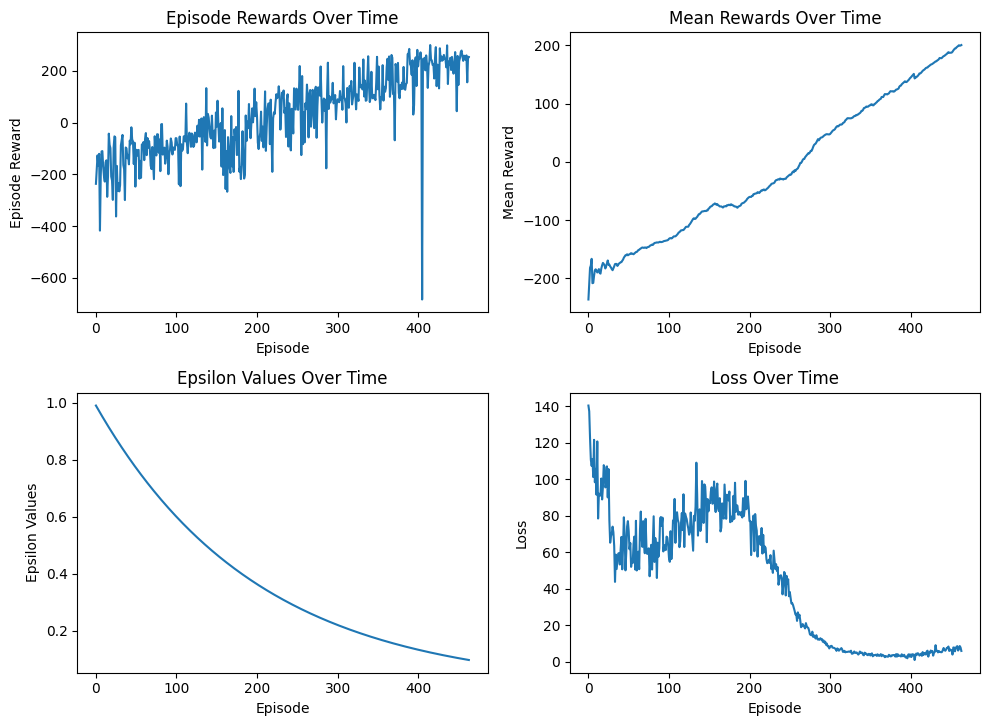

>>> Training completed at  2024-11-25 16:00:00.845219


In [25]:
net = DQN (env, learning_rate=LR, device='cpu')

buffer = NStepReplayBuffer(capacity=MEMORY_SIZE, n_step=2, gamma=GAMMA)

agent = NstepDQNAgent (env, net, buffer, epsilon=EPSILON, eps_decay=EPSILON_DECAY, batch_size=BATCH_SIZE)

agent.train(gamma=GAMMA, max_episodes=MAX_EPISODES, 
              batch_size=BATCH_SIZE,
              dnn_update_frequency=DNN_UPD,
              dnn_sync_frequency=DNN_SYNC)

print(">>> Training completed at ",datetime.datetime.now())

In [26]:
wandb.finish()

episode,▁▁▁▂▂▂▂▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇███
episode reward,▁▄▄▂▃▄▅▃▄▅▄▄▄▄▅▄▄▅▄▅▅▅▅▆▆▄▆▇▆▆▇▆▆▆████▇█
epsilon,██▇▇▆▆▆▆▅▅▅▅▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
loss,▇▇█▄▅▄▆▄▄▆▅▅▅▇▆▇▇▆▆▆▆▆▅▅▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
mean_rewards,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▆▆▆▆▆▆▇▇███
episode,464
episode reward,253.62361
epsilon,0.09721
loss,6.03574
mean_rewards,200.32041


<span style="color: lightblue;">

In this case the training also converged later than the baseline one, nevertheless it's closer to the baseline convergence than the dueling was.

This problem of converging a bit later than the baseline (which Dueling DQN also has), is probably due to the grid search not being with a wide enough range of parameters to actually select the best ones. I believe i might have gotten a suboptimal set of parameters that make the extensions of the algorithm perform very similarly to the baseline model.

</span>

## Part 2. REINFORCE Agent

In this section, we will implement the **REINFORCE algorithm**, incorporating a standardized average reward as a **baseline**.

Main Steps:
1. Define the neural network model for the policy.
2. Implement the agent.
3. Train the agent, experimenting with different hyperparameters and fine-tuning the model.
4. Save the best-performing model in `.pth` format.
5. Finally, test the trained agent's performance.

We will use the **standardized average return as a baseline**, calculated from the discounted rewards using the following formula:

$$ \frac{x_i - \bar{x}}{\sigma_x} $$

<u>Questions</u> (**4 points**): 

1. Model Implementation: Provide detailed comments explaining the model architecture and the key parts of the code.
2. Hyperparameter Justification: Explain the rationale behind your choice of hyperparameters during training.
3. Training Analysis: For the best-performing model, plot the following metrics over the course of training:

- Total rewards obtained throughout training.
- The rolling average of rewards every 100 episodes.
- The reward threshold defined by the environment.
- The evolution of the loss function during training.

4. Model Testing: Load the trained model and run it for 100 consecutive episodes. Plot the sum of rewards for each episode, along with the environment's reward threshold.
5. Result Commentary: Analyze and comment on the performance of the trained agent based on the results.

<div class="alert alert-block alert-danger">
<strong>Solution</strong>
</div>

### Implementation:

<span style="color: lightblue;">
To implement the REINFORCE with a baseline, we use the whitening technique which is the simplest and most common. We normalize the return of each step of the episode. 
The baseline used is the standardized mean:

$$ \frac{x_i - \bar{x}}{\sigma_x} $$

which means that we end up having:

$$ \theta_{t+1} = \theta + \alpha (G_t - (\frac{x_i - \bar{x}}{\sigma_x})) \nabla ln \pi (A_t|S_t, \theta) $$

</span>

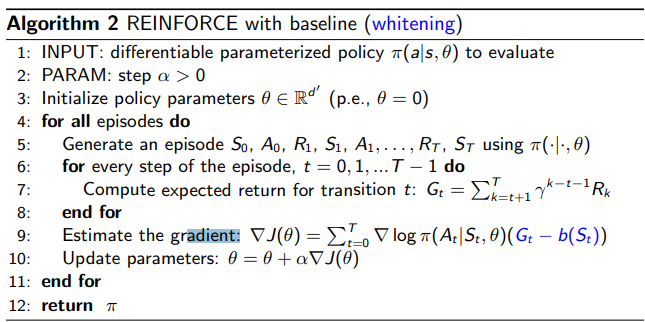

<span style="color: lightblue;">
To follow this pseudocode, we first create a policy model. add the optimizer which will be used for training the policy parameters (line 10 of pseudocode)

- We add two functions that will be used to compute the expected return for transition t (line 7)

- The training loop first sets a list to track the scores to use for visualization
- Then for all episodes, it creates an episode using the policy. 
- For each timestep of the episode, it computes the expected return and then estimate the gradient. 
- Finally, it updates the policy. 

Additionally, we plot the scores and the average scores. 
At the end, we save the model. 

</span>

In [2]:
# Hyperparameters
HIDDEN_SIZE = 256
LEARNING_RATE = 0.003
GAMMA = 0.99
HORIZON = 500
MAX_TRAJECTORIES = 1000

In [3]:
# Environment setup
obs_size = env.observation_space.shape[0]
n_actions = env.action_space.n

# Define the policy model
model = nn.Sequential(
    nn.Linear(obs_size, HIDDEN_SIZE),
    nn.ReLU(),
    nn.Linear(HIDDEN_SIZE, n_actions),
    nn.Softmax(dim=-1)
)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE) # Optimizer for training the policy parameters θ (pseudocode line 10 diapo 59)

In [4]:
# Function to calculate discounted rewards
def calculate_discounted_rewards(rewards, gamma):
    discounted_rewards = []
    g = 0
    for reward in reversed(rewards):
        g = reward + gamma * g # expected return at time t (line 7 in pseudocode)
        discounted_rewards.insert(0, g)
    return np.array(discounted_rewards)

# Function to standardize rewards
def standardize_rewards(rewards):
    mean = np.mean(rewards) # Mean of the rewards
    std = np.std(rewards) + 1e-8  # std
    return (rewards - mean) / std

### Fine tune hyperparameters (grid search):

In [ ]:
# Define the grid of hyperparameters
hyperparameter_grid = {
    "HIDDEN_SIZE": [128, 256],
    "LEARNING_RATE": [0.001, 0.0001],
    "GAMMA": [0.95, 0.99],
    "HORIZON": [200, 500],
    "MAX_TRAJECTORIES": [1000, 2000]
}

# Get all combinations of hyperparameter values
grid_combinations = list(itertools.product(*hyperparameter_grid.values()))
hyperparameter_names = list(hyperparameter_grid.keys())

wandb.login()

# Gridseearch loop
best_score = -float('inf')
best_params = None

for params in grid_combinations:
    config = dict(zip(hyperparameter_names, params))
    
    # Set hyperparameters
    HIDDEN_SIZE = config["HIDDEN_SIZE"]
    LEARNING_RATE = config["LEARNING_RATE"]
    GAMMA = config["GAMMA"]
    HORIZON = config["HORIZON"]
    MAX_TRAJECTORIES = config["MAX_TRAJECTORIES"]
    
    #  model
    model = nn.Sequential(
        nn.Linear(obs_size, HIDDEN_SIZE),
        nn.ReLU(),
        nn.Linear(HIDDEN_SIZE, n_actions),
        nn.Softmax(dim=-1)
    )
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    wandb.init(project="PML_PLAB2_LunarLander_Reinforce", config=config)
    
    scores = []
    mean_rewards = deque(maxlen=100)  # Rolling mean of the last 100 episode rewards

    for trajectory in range(MAX_TRAJECTORIES):
        state, _ = env.reset()
        done = False
        transitions = []
        total_reward = 0  # Total reward for the current episode
        
        # Generate an episode
        for t in range(HORIZON):
            state_tensor = torch.from_numpy(state).float()
            action_probs = model(state_tensor)
            action = np.random.choice(n_actions, p=action_probs.detach().numpy())
            
            next_state, reward, terminated, truncated, _ = env.step(action)
            transitions.append((state, action, reward))
            total_reward += reward
            state = next_state
            
            if terminated or truncated:
                break
        
        # Process episode rewards
        states, actions, rewards = zip(*transitions)
        rewards = np.array(rewards)
        discounted_rewards = calculate_discounted_rewards(rewards, GAMMA)
        standardized_rewards = standardize_rewards(discounted_rewards)
        
        # Prepare tensors
        state_batch = torch.tensor(states, dtype=torch.float32)
        action_batch = torch.tensor(actions, dtype=torch.long)
        reward_batch = torch.tensor(standardized_rewards, dtype=torch.float32)
        
        # Compute loss
        action_probs = model(state_batch)
        selected_action_probs = action_probs.gather(1, action_batch.view(-1, 1)).squeeze()
        loss = -torch.sum(torch.log(selected_action_probs) * reward_batch)
        
        # Update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Track scores and mean rewards
        scores.append(total_reward)
        mean_rewards.append(total_reward)

        wandb.log({
            'episode': trajectory,
            'loss': loss.item(),
            'episode reward': total_reward,
            'mean_rewards': np.mean(mean_rewards)
        }, step=trajectory)
        
        if trajectory % 50 == 0 and trajectory > 0:
            avg_score = np.mean(mean_rewards)
            print(f"Params: {config}, Episode {trajectory}\tMean Reward (last 100): {avg_score:.2f}")

    # Evaluate performance and track the best hyperparameters
    final_avg_score = np.mean(mean_rewards)
    if final_avg_score > best_score:
        best_score = final_avg_score
        best_params = config
    
    wandb.finish()

In [32]:
print("Best Hyperparameters:", best_params)
print("Best Average Score:", best_score)

Best Hyperparameters: {'HIDDEN_SIZE': 128, 'LEARNING_RATE': 0.001, 'GAMMA': 0.99, 'HORIZON': 500, 'MAX_TRAJECTORIES': 2000}
Best Average Score: 107.56609976204676


<span style="color: lightblue;">

I have, again, cleared the output due to it being too long. 

<img src="Reinforce wandb.png" alt="Baseline WandB Graph" width="45%"/>  <img src="reinforce mean.png" alt="Baseline WandB Graph" width="45%"/>


The one with the highest mean rewards is Pious durian which has the following parameters:

- GAMMA = 0.99
- HIDDEN_SIZE = 128
- HORIZON = 500
- LEARNING_RATE = 0.001
- MAX_EPISODES = 2000

This gives the following episode rewards evolution:

<img src="reinforce ep_rewards.png" alt="Baseline WandB Graph" width="50%"/>

And has the following loss:

<img src="reinforce loss.png" alt="Baseline WandB Graph" width="50%"/>


The four combinations of the parameters that end up higher in the grid search all have in common:
- GAMMA = 0.99
- LEARNING_RATE = 0.001
- MAX_EPISODES = 2000

While the 5 that ended up last in the grid search have in common:
- GAMMA = 0.95
- LEARNING_RATE = 0.0001
- MAX_EPISODES = 1000

The values that i intend to use are the ones that have the highest average score. However, to train the reinforce agent i want to try if it gets better when i give it more episodes. I am aware (thanks to previous trial runs) that the reinforce algorithm needs more episodes to converge. However, i wanted to keep the grid search somewhat quick. So i will now try to see if giving it more time, it converges to higher values since in this grid search, the highest score does not achieve to get to the reward threshold described by the environment. If it flatlines for a long time (say more than 7k or 8k episodes), i will assume there is not much room for improvement and will stop the execution. 

</span>

### Training:

In [10]:
HIDDEN_SIZE = 128
LEARNING_RATE = 0.001
GAMMA = 0.99
HORIZON = 500
MAX_TRAJECTORIES = 10000

In [11]:
# Environment setup
obs_size = env.observation_space.shape[0]
n_actions = env.action_space.n

# Define the policy model
model = nn.Sequential(
    nn.Linear(obs_size, HIDDEN_SIZE),
    nn.ReLU(),
    nn.Linear(HIDDEN_SIZE, n_actions),
    nn.Softmax(dim=-1)
)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE) # Optimizer for training the policy parameters θ (pseudocode line 10 diapo 59)

In [12]:
wandb.login()

wandb.init(project="PML_PLAB2_LunarLander", config={
    "HIDDEN_SIZE": HIDDEN_SIZE,
    "LEARNING_RATE": LEARNING_RATE,
    "GAMMA": GAMMA,
    "HORIZON": HORIZON,
    "MAX_TRAJECTORIES": MAX_TRAJECTORIES,
    "REINFORCE": True
})

print(">>> Training starts at ",datetime.datetime.now())

>>> Training starts at  2024-11-26 22:19:52.211246


In [13]:
scores = []  # Track total rewards for each episode
mean_rewards = deque(maxlen=100)  # Rolling window of the last 100 rewards
losses = []  # Track the loss for each episode

# for all episodes: 
for trajectory in range(MAX_TRAJECTORIES):
    state, _ = env.reset()
    done = False
    transitions = []  # Store state-action-reward tuples for the episode
    total_reward = 0  # Track total reward for the episode

    # Collect a trajectory (generate an episode)
    for t in range(HORIZON):
        state_tensor = torch.from_numpy(state).float()  # Convert state to tensor
        action_probs = model(state_tensor)  # Get action probabilities
        action = np.random.choice(n_actions, p=action_probs.detach().numpy())  # Select one

        next_state, reward, terminated, truncated, _ = env.step(action)
        transitions.append((state, action, reward))  # Record transition (S_t, A_t, R_t)
        total_reward += reward  # Accumulate reward for the episode
        state = next_state

        if terminated or truncated:
            break

    # Process rewards and calculate baseline (line 7)
    states, actions, rewards = zip(*transitions)
    rewards = np.array(rewards)
    discounted_rewards = calculate_discounted_rewards(rewards, GAMMA)  # Compute Gt for each step
    standardized_rewards = standardize_rewards(discounted_rewards)  # Normalize the rewards

    # Convert to tensors
    state_batch = torch.tensor(states, dtype=torch.float32)
    action_batch = torch.tensor(actions, dtype=torch.long)
    reward_batch = torch.tensor(standardized_rewards, dtype=torch.float32)

    # Calculate loss (pseudocode 9)
    action_probs = model(state_batch)
    selected_action_probs = action_probs.gather(1, action_batch.view(-1, 1)).squeeze()
    loss = -torch.sum(torch.log(selected_action_probs) * reward_batch)

    # Update policy parameters (line 10)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Log episode rewards
    scores.append(total_reward)  # Append the total reward for this episode
    mean_rewards.append(total_reward)  # Add to the rolling window for mean computation
    losses.append(loss.item())  # Track the loss for this episode

    # Log progress every 50 episodes
    if trajectory % 50 == 0 and trajectory > 0:
        print(f"Episode {trajectory}\tMean reward (last 100): {np.mean(mean_rewards):.2f}")
        
    if np.mean(mean_rewards) >= env.spec.reward_threshold:
        print(f"Environment solved in {trajectory} episodes!")
        break

    # Log metrics to wandb
    wandb.log({
        'episode': trajectory,
        'episode reward': total_reward,  # Log the total reward for the episode
        'mean_rewards': np.mean(mean_rewards),  # Log the mean reward over the last 100 episodes
        'loss': loss.item()
    }, step=trajectory)


Episode 50	Mean reward (last 100): -184.94
Episode 100	Mean reward (last 100): -180.47
Episode 150	Mean reward (last 100): -157.03
Episode 200	Mean reward (last 100): -146.97
Episode 250	Mean reward (last 100): -154.52
Episode 300	Mean reward (last 100): -146.74
Episode 350	Mean reward (last 100): -130.82
Episode 400	Mean reward (last 100): -110.39
Episode 450	Mean reward (last 100): -104.43
Episode 500	Mean reward (last 100): -102.13
Episode 550	Mean reward (last 100): -98.61
Episode 600	Mean reward (last 100): -89.83
Episode 650	Mean reward (last 100): -78.60
Episode 700	Mean reward (last 100): -74.39
Episode 750	Mean reward (last 100): -44.70
Episode 800	Mean reward (last 100): -25.68
Episode 850	Mean reward (last 100): -19.24
Episode 900	Mean reward (last 100): 2.76
Episode 950	Mean reward (last 100): 18.30
Episode 1000	Mean reward (last 100): 19.60
Episode 1050	Mean reward (last 100): 12.97
Episode 1100	Mean reward (last 100): 7.53
Episode 1150	Mean reward (last 100): 18.98
Episod

In [14]:
print(">>> Training completed at ",datetime.datetime.now())
wandb.finish()

>>> Training completed at  2024-11-26 22:22:58.114289


episode,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇█
episode reward,▃▁▂▂▂▃▃▄▅▆▆▆▆▆▇▃▆▆▄▆▇▆▄▆▅▇▂▆▆▆▇▆▆▄▆▆▆▆██
loss,▄▄▄▄▄▄▅▄▄▄▃▄▃▃▃▄▃▃▃▃▂▃▂▂▂▂▂▂▄▁▃▄▃▄▄▄▄▄▆█
mean_rewards,▁▁▁▁▁▃▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇▇▇▇█▇█
episode,4134
episode reward,243.17457
loss,-65.62147
mean_rewards,199.32964


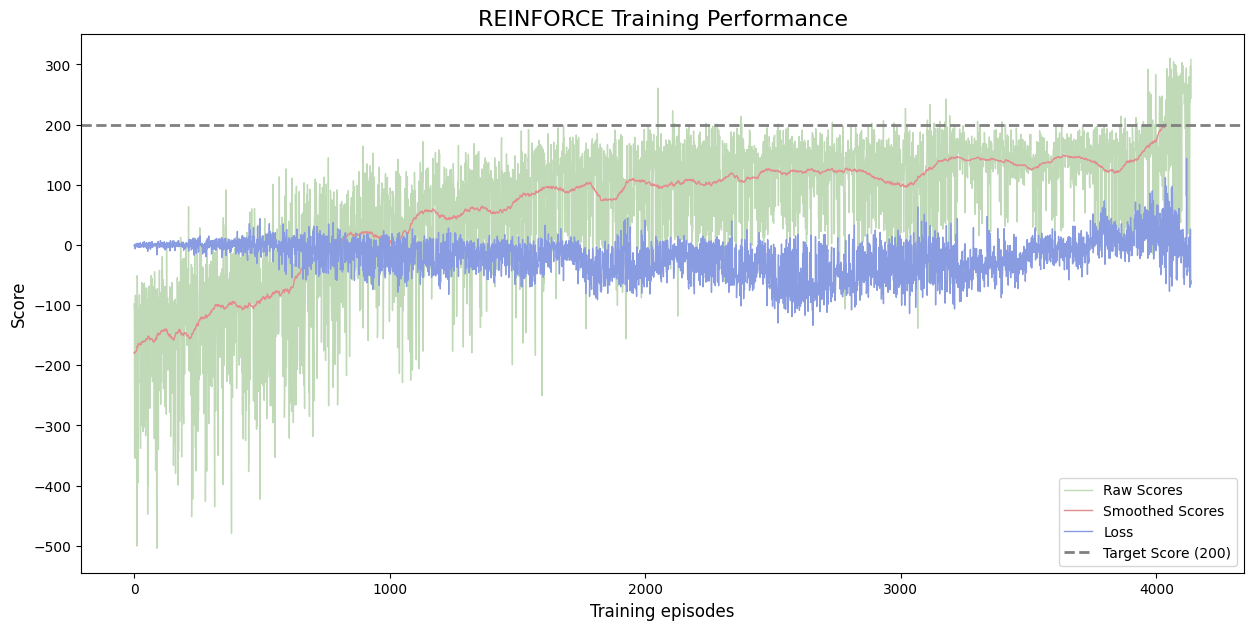

In [15]:
# Plot
rewards = np.array(scores)
window_size = 100
mean_rewards = np.convolve(rewards, np.ones(window_size) / window_size, mode='valid')
loss = np.array(losses)

plt.figure(figsize=(15, 7))

plt.title("REINFORCE Training Performance", fontsize=16)
plt.ylabel("Score", fontsize=12)
plt.xlabel("Training episodes", fontsize=12)

plt.plot(rewards, color='#c0d9b7', linewidth=1, label="Raw Scores")
plt.plot(mean_rewards, color='#e38e8e', linewidth=1, label="Smoothed Scores")
plt.plot(loss, color='#899ce1', linewidth=1, label="Loss")
plt.axhline(y=200, color='gray', linestyle='--', linewidth=2, label="Target Score (200)")

plt.legend()
plt.show()

# Save the model
torch.save(model.state_dict(), "reinforce_model.pth")

### Testing:

In [16]:
obs_size = env.observation_space.shape[0]
n_actions = env.action_space.n

# Define the policy model
model2 = nn.Sequential(
    nn.Linear(obs_size, HIDDEN_SIZE),
    nn.ReLU(),
    nn.Linear(HIDDEN_SIZE, n_actions),
    nn.Softmax(dim=-1)
)

model2.load_state_dict(torch.load("reinforce_model.pth"))
model2.eval()

C:\Users\adminlocal\AppData\Local\Temp\ipykernel_8204\2283655715.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model2.load_state_dict(torch.load("reinforce_model.pth"

Sequential(
  (0): Linear(in_features=8, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=4, bias=True)
  (3): Softmax(dim=-1)
)

In [17]:
def watch_agent(env, model, best_score_test):
    state, _ = env.reset()
    total_reward = 0  # Record rewards
    images = []  # Record rendered frames

    for _ in range(1000):  # Max 2000 steps
        state_tensor = torch.from_numpy(state).float()
        action_probs = model(state_tensor)
        action = np.random.choice(n_actions, p=action_probs.detach().numpy())

        # Get rendered frame as an RGB array
        img = env.render()
        if img is not None:  # Check if the render method returns a valid image
            images.append(Image.fromarray(img))

        state, reward, terminated, truncated, _ = env.step(action)
        total_reward += reward

        if terminated or truncated:
            print("Total Reward:", total_reward)
            break

    # Save the images as a GIF
    if images and best_score_test < total_reward:
        images[0].save("video.gif", save_all=True, append_images=images[1:], duration=60, loop=0)
        best_score_test = total_reward
    else:
        print("No frames were captured.")

    env.close()
    return total_reward, best_score_test

# Ensure render mode is set to 'rgb_array'
env = gym.make('LunarLander-v3', render_mode="rgb_array")

## TESTING: Load the model and watch the agent play for 100 episodes
reward_episode = []
best_score_test = -float('inf') # To track the best test and keep the gif
for i in range(100):
    print(f"Episode {i + 1}")
    reward, best_score_test = watch_agent(env, model2, best_score_test)
    reward_episode.append(reward)
    
print("Average reward over 100 episodes:", np.mean(reward_episode))
print("Best score in testing:", best_score_test)

Episode 1
Total Reward: 302.9387712738506
Episode 2
Total Reward: 280.091397150154
No frames were captured.
Episode 3
Total Reward: 219.18429666328745
No frames were captured.
Episode 4
Total Reward: 230.42647741892813
No frames were captured.
Episode 5
Total Reward: 274.7033422365987
No frames were captured.
Episode 6
Total Reward: 249.00825049635816
No frames were captured.
Episode 7
Total Reward: 275.65141865847994
No frames were captured.
Episode 8
Total Reward: 218.6328130293558
No frames were captured.
Episode 9
Total Reward: 229.146002343906
No frames were captured.
Episode 10
Total Reward: 244.502755218555
No frames were captured.
Episode 11
Total Reward: 288.20539215419774
No frames were captured.
Episode 12
Total Reward: 293.72633494305626
No frames were captured.
Episode 13
Total Reward: 245.4151421534336
No frames were captured.
Episode 14
Total Reward: 290.3524711816705
No frames were captured.
Episode 15
Total Reward: 234.78810280888086
No frames were captured.
Episode 16

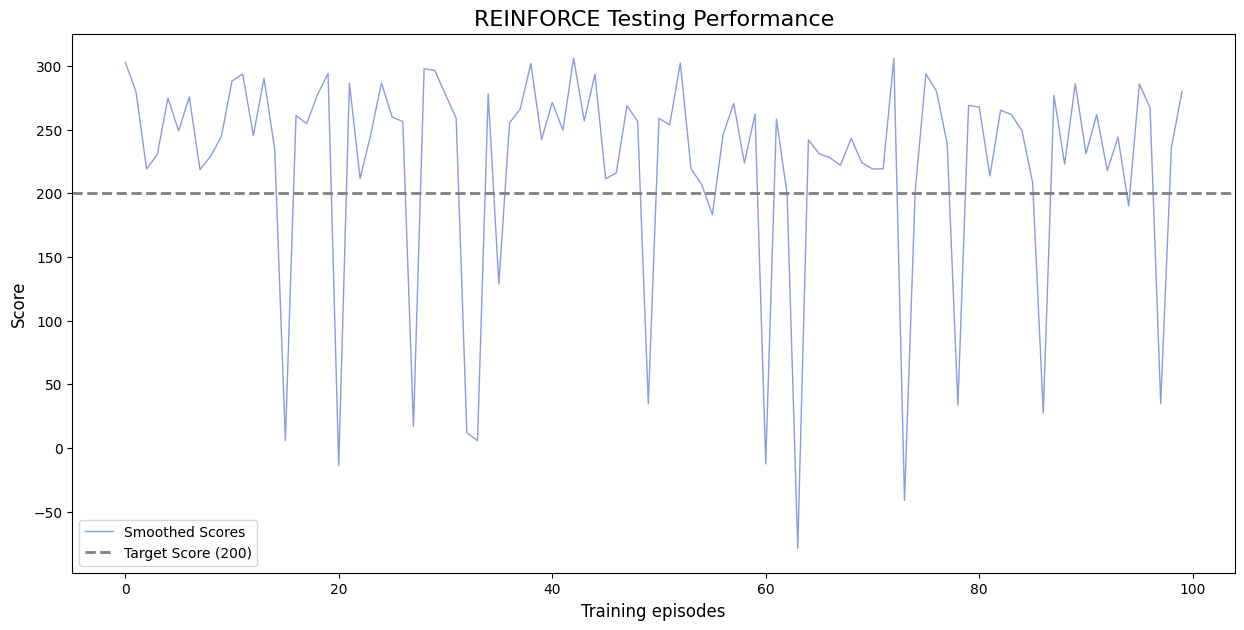

In [18]:
# Plot:
reward_episode = np.array(reward_episode)

plt.figure(figsize=(15, 7))

plt.title("REINFORCE Testing Performance", fontsize=16)
plt.ylabel("Score", fontsize=12)
plt.xlabel("Training episodes", fontsize=12)

plt.plot(reward_episode, color='#899ce1', linewidth=1, label="Smoothed Scores")
plt.axhline(y=200, color='gray', linestyle='--', linewidth=2, label="Target Score (200)")

plt.legend()
plt.show()

<span style="color: lightblue;">
Best testing episode:



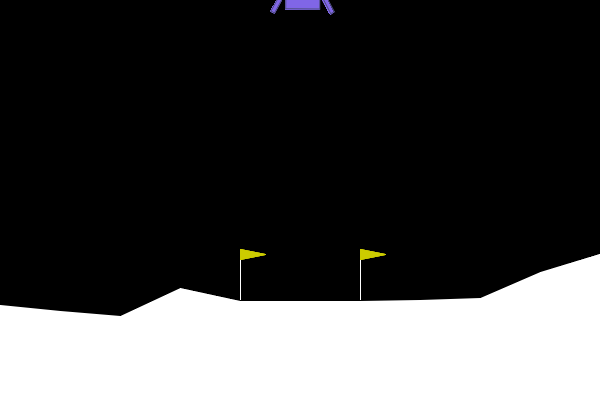

</span>


### Result commentary:

Analyze and comment on the performance of the trained agent based on the results.

<span style="color: lightblue;">

RESULSTS: After analyzing the test performance. It's clear that it has improved learning insights of the game compared to the agent which would choose randomly. Seeing the plot helps me see what is more or less the rewards that the agent is getting after the 100 testing episodes. If we look at the y axis, we can see that the range is mostly positive meaning that with some exceptions, most of the testing episodes have a positive reward.
According to the documentation, 

For each step, the reward:
- is increased/decreased the closer/further the lander is to the landing pad.
- is increased/decreased the slower/faster the lander is moving.
- is decreased the more the lander is tilted (angle not horizontal).
- is increased by 10 points for each leg that is in contact with the ground.
- is decreased by 0.03 points each frame a side engine is firing.
- is decreased by 0.3 points each frame the main engine is firing.

The episode receive an additional reward of -100 or +100 points for crashing or landing safely respectively.
An episode is considered a solution if it scores at least 200 points.

In general, the agent has learned well given that ```Average reward over 100 episodes: 222.38``` this means that it either spends little time in the episodes, doesn't go from side to side, has both legs in contact with the ground, it lands safely (and combinations of the possibilities mentioned above). 

The reward for moving from the top of the screen to the landing pad and coming to rest is about 100-140 points, so this is likely the case. The agent probably learned to move towards the landing pad and achieve proximity-based rewards while maintaining a stable descent.

In the cases the score is below 100, it probably means that the agent did not land but it didn't crash either, which points to the possibility of the agent hovering over the ground (but that doesn't get negative rewards due to the spaceship not having a firing agent). 

In the cases the agent got a negative reward, it's likely due to either:

- The agent crashing but not spending a lot of time in the game (-100 for crashing but positive little rewards for not firing the engine, getting close to the landing pad...)

    or

- Getting several negative rewards (spending a lot of time from left to right, moving slow, having a firing engine...) and then land (but the negative rewards were not cancelled since they were - a value that is higher than 100), crash, or hover

Regarding how the agent learned, the majority of scores are positive, with exceptions. This suggests the agent consistently learns policies that lead to decent behavior (avoiding crashes and possibly completing partial objectives). As previously mentioned, the games in which the agent had a positive yet lower than 100 reward show that the agent has partial knowledge of optimal behaviors but still is not perfect to control each and every episode. The policy could improve in the scenarios where the agent got negative rewards from crashing, using too much engine, inefficient movements...

I think the agent might have found a local optimum which makes it perform decently well in many cases but lacks consistency across all possibilities. This could be improved with longer training, more hyperparameter experimentation, trials of more models or combinations of the tried ones...

</span>

<span style="color: lightblue;">

----------------------------------------------------------------------------------------------------------------------------------------

</span>

<span style="color: lightblue;">

I have used ChatGPT to get the code to plot and the grid search. 

</span>